## Разведочный анализ данных, подготовка и очистка данных, построение модели машинного обучения для задачи классификации

## Информация о датасете bank marketing

https://www.kaggle.com/datasets/janiobachmann/bank-marketing-dataset

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable deposit).

Информация о переменных:

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('bank-marketing-dataset.csv', header=0, sep=',')

In [8]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


Признак duration (время разговора) неизвестен до самого звонка клиенту, он сильно коррелирует 
с выходной переменной, тем более после звонка результат уже известен, для построения более реальной модели я решил его исключить

In [10]:
df.drop('duration',axis=1,inplace=True)

Для удобства займемся небольшим Feature Engineering - бинарно закодируем категориальные метки со значениями 'yes' или 'no'

In [12]:
df[['deposit','default','housing','loan']] = df[['deposit','default','housing','loan']].replace({'yes':1, 'no':0})

In [13]:
df.shape

(11162, 16)

Пропуски np.nan отсутствуют в датасете

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  int64 
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  int64 
 7   loan       11162 non-null  int64 
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  campaign   11162 non-null  int64 
 12  pdays      11162 non-null  int64 
 13  previous   11162 non-null  int64 
 14  poutcome   11162 non-null  object
 15  deposit    11162 non-null  int64 
dtypes: int64(10), object(6)
memory usage: 1.4+ MB


## Изучение целевого признака

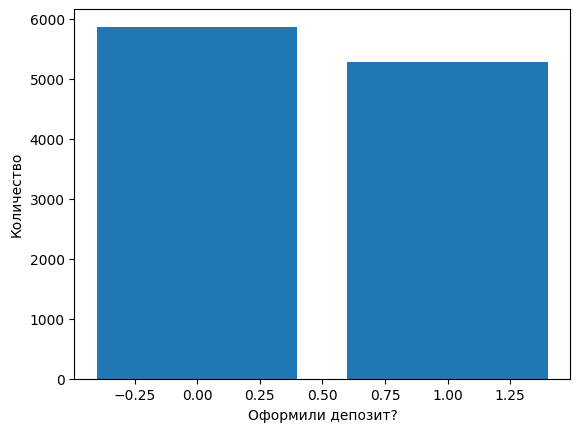

In [18]:
data = df['deposit'].value_counts().reset_index()
plt.bar(data['deposit'],data['count'])
plt.xlabel('Оформили депозит?')
plt.ylabel('Количество')
plt.show()

Имеется совсем небольшой дислабаланс классов, но в целом набор данных сбалансирован по двум классам

## Изучение признаков

In [21]:
df.describe()

,age,default,balance,housing,loan,day,campaign,pdays,previous,deposit
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,0.015051,1528.538524,0.473123,0.130801,15.658036,2.508421,51.330407,0.832557,0.473840
std,11.913369,0.121761,3225.413326,0.499299,0.337198,8.420740,2.722077,108.758282,2.292007,0.499338
min,18.000000,0.000000,-6847.000000,0.000000,0.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,32.000000,0.000000,122.000000,0.000000,0.000000,8.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,0.000000,550.000000,0.000000,0.000000,15.000000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,0.000000,1708.000000,1.000000,0.000000,22.000000,3.000000,20.750000,1.000000,1.000000
max,95.000000,1.000000,81204.000000,1.000000,1.000000,31.000000,63.000000,854.000000,58.000000,1.000000


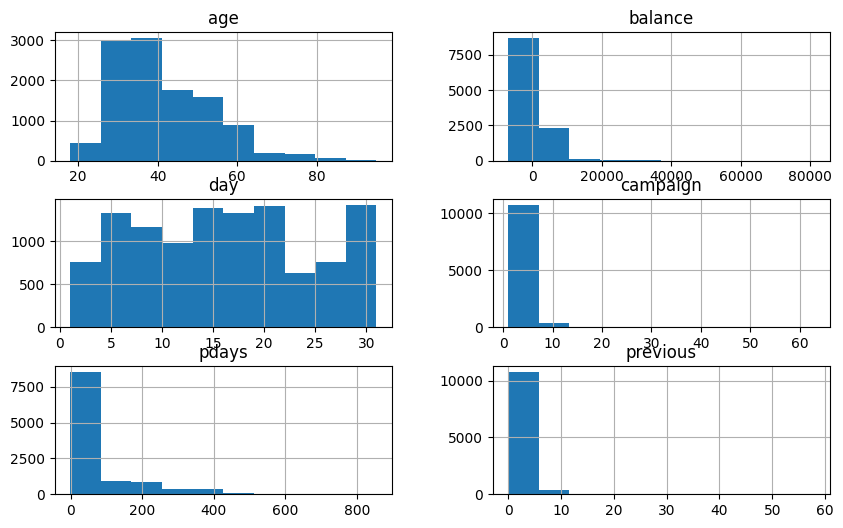

In [22]:
num_cols = ['age','balance','day','campaign','pdays','previous']
df[num_cols].hist(figsize=(10,6))
plt.show()

Признак age имеет распределение, похожее на нормальное.
В признаках balance, campaign, pdays, previous возможны выбросы, все эти распределения смещены влево

Изучим категориальные признаки

In [25]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,0,2343,1,0,unknown,5,may,1,-1,0,unknown,1
1,56,admin.,married,secondary,0,45,0,0,unknown,5,may,1,-1,0,unknown,1
2,41,technician,married,secondary,0,1270,1,0,unknown,5,may,1,-1,0,unknown,1
3,55,services,married,secondary,0,2476,1,0,unknown,5,may,1,-1,0,unknown,1
4,54,admin.,married,tertiary,0,184,0,0,unknown,5,may,2,-1,0,unknown,1


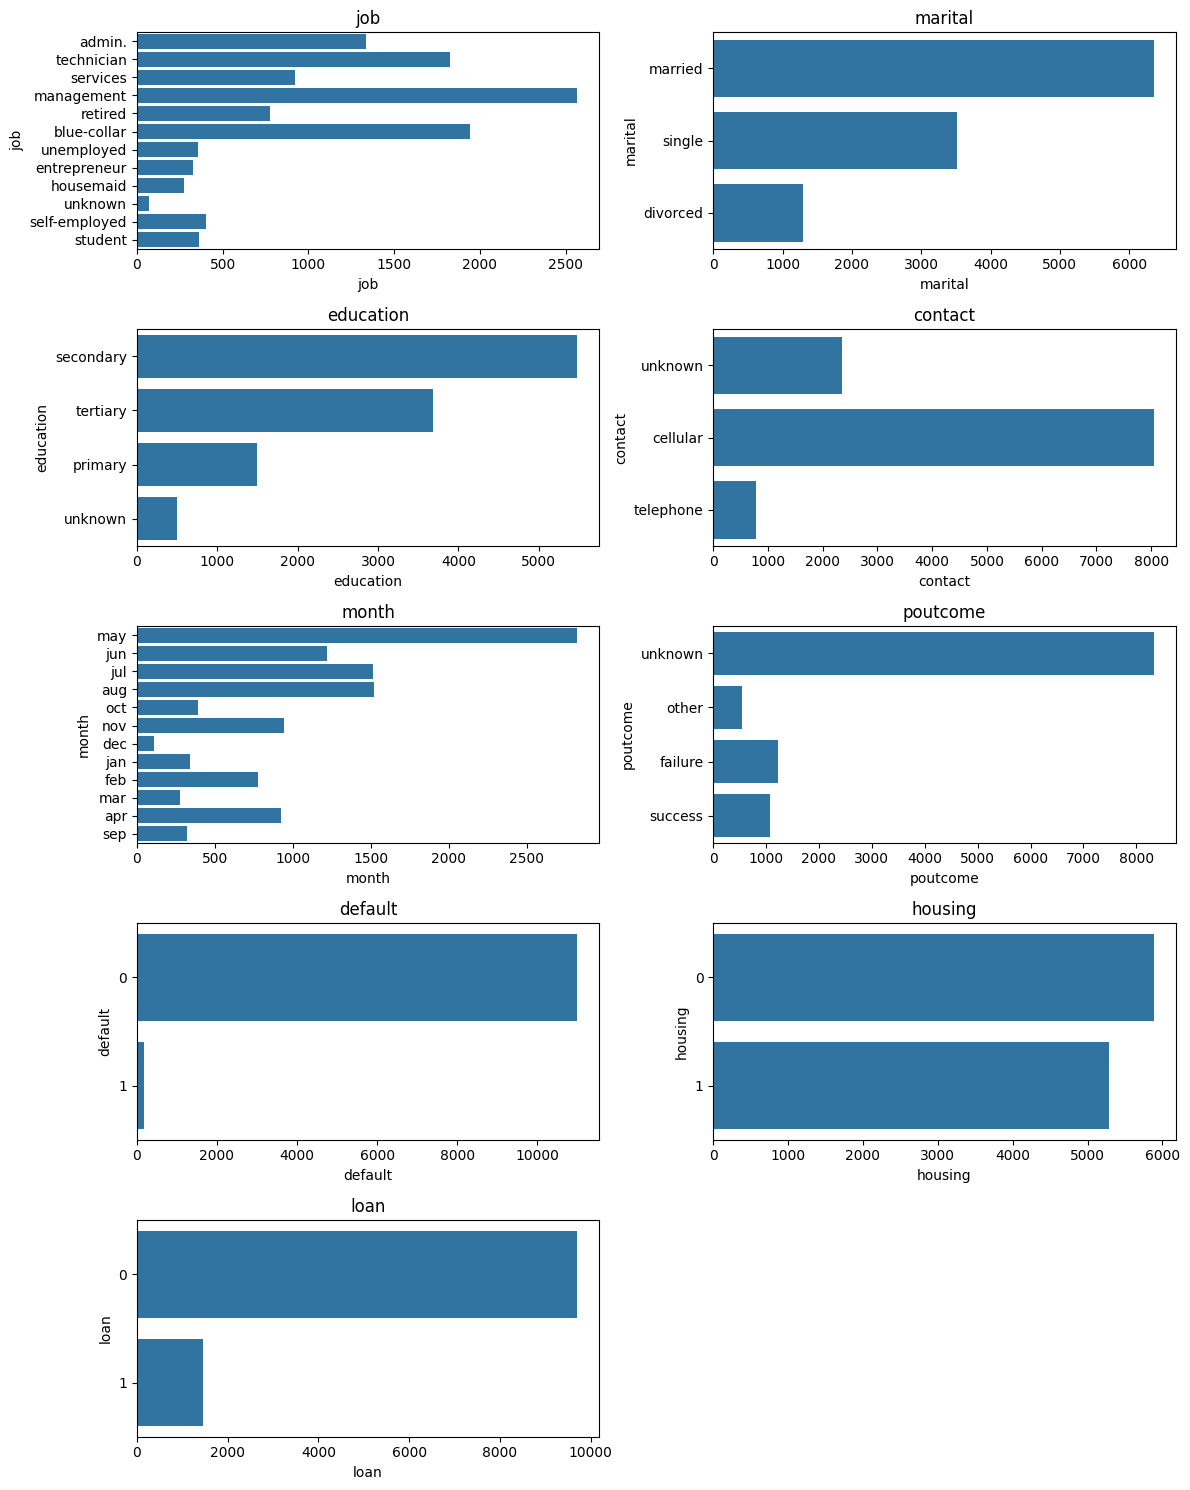

In [26]:
cat_col = ['job','marital','education','contact','month','poutcome','default','housing', 'loan']
plt.figure(figsize=(12,15))
plotnumber = 1
for cat_feature in cat_col:
    ax = plt.subplot(5,2,plotnumber)
    sns.countplot(y=cat_feature,data=df)
    plt.xlabel(cat_feature)
    plt.title(cat_feature)
    plt.tight_layout()
    plotnumber+=1
plt.show()

Из данных распределений категориальных переменных можно сделать следующие выводы:

- Самая встречающаяся работа - менеджер (мода переменной job)
- Больше всего людей в браке (married)
- Большинство людей имеют среднее образование
- Чаще всего используется сотовый телефон
- Самый пик телефонных звонков приходится на конец весны-начало лета
- Большинство людей не имели задолженностей
- Большинство людей не имеют заем

## Изучение влияния признаков на целевую переменную

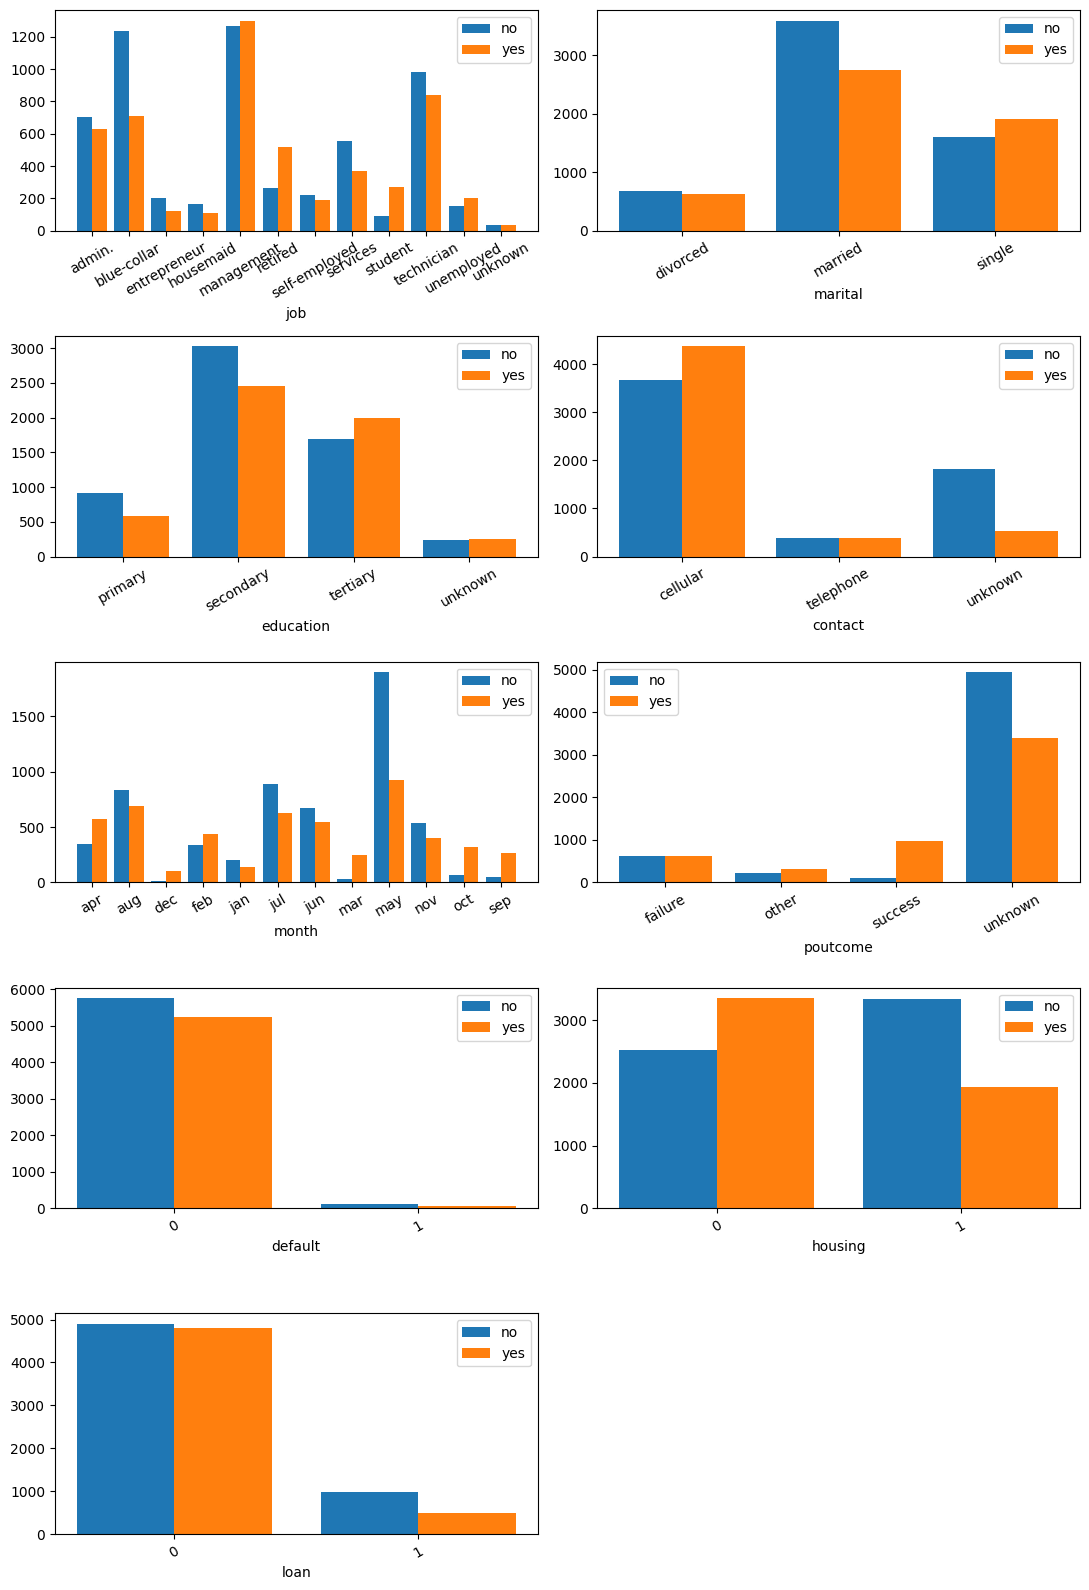

In [29]:
plotnumber = 1
plt.figure(figsize=(11, 16))
for cat_feature in cat_col:
    data = df.groupby(cat_feature).agg({cat_feature:'count','deposit':'sum'})
    ax = plt.subplot(5,2,plotnumber)
    n_ticks = np.arange(len(data['deposit']))
    offset = 0.2
    w = 0.4
    ax.bar(n_ticks - offset, data[cat_feature]-data['deposit'], width=w)
    ax.bar(n_ticks + offset, data['deposit'], width=w)
    
    plt.xlabel(cat_feature)
    #plt.title(cat_feature)
    ax.legend(['no', 'yes'])
    plt.xticks(n_ticks, data.index, rotation = 30)  # добавляем метки делений
    #print(df.groupby('job').agg({'job':'count','deposit':'sum'}))
    plt.tight_layout()
    plotnumber += 1

        
    

Из данных графиков можно понять, что:

- Студенты более охотно соглашаются на депозит
- Холостые более часто берут депозит
- Люди с образованием tertitary более склонны взять депозит
- Если ранее прошлая компания с человеком прошла успешно, то и нынешняя с большим шансом будет успешна
- В феврале, марте, апреле, сентябре, октябре люди чаще всего соглашались на депозит, но наибольшую часть депозитов оформили в мае
- Люди с жилищным кредитом, так и с обычным займом, реже оформляют депозит

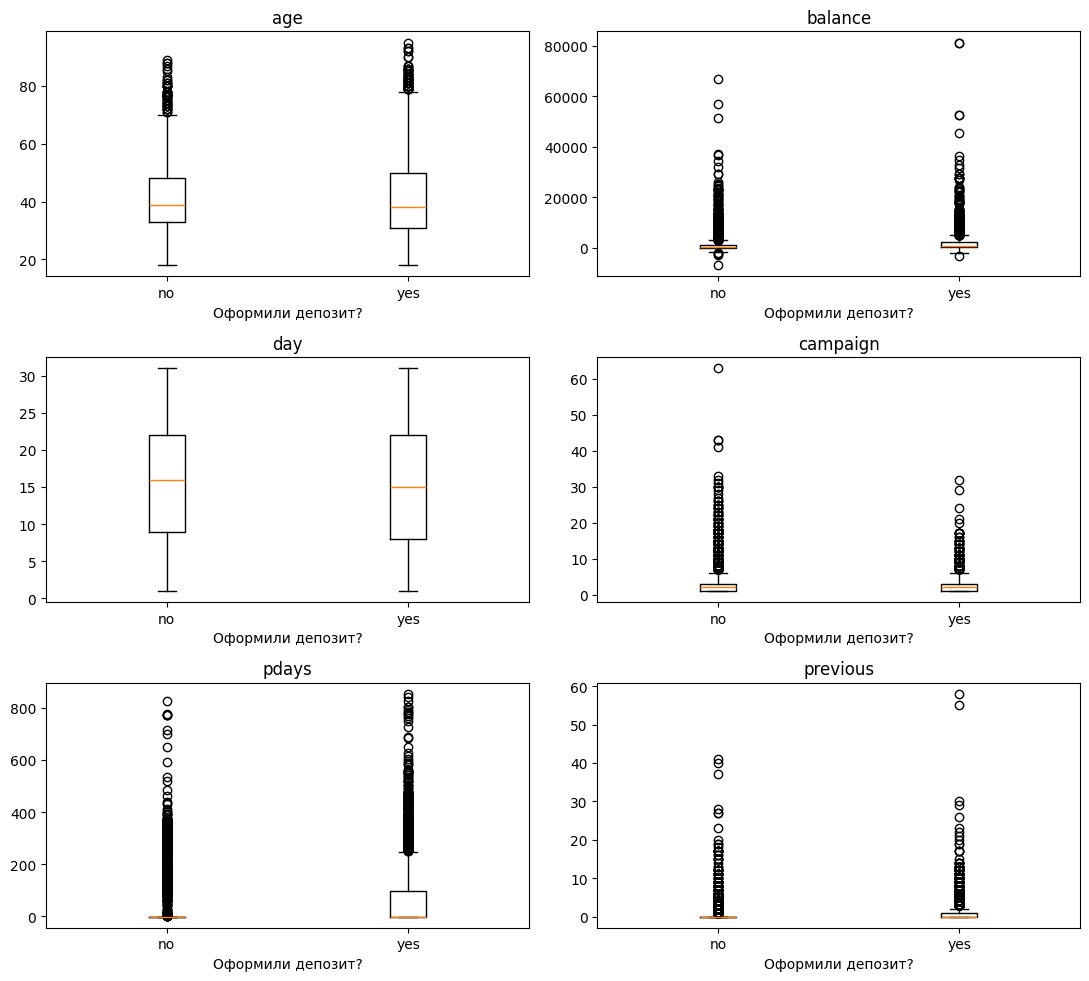

In [31]:

plotnumber = 1
plt.figure(figsize=(11, 16))
for num_feature in num_cols:
    ax = plt.subplot(5,2,plotnumber)
    plt.boxplot([df[df['deposit'] == 0][num_feature], df[df['deposit'] == 1][num_feature]])
    plt.xticks([1,2],['no','yes'])
    plt.xlabel('Оформили депозит?')

    plt.title(num_feature)
    #ax.legend(['no', 'yes'])
    #plt.xticks(n_ticks, data.index, rotation = 30)  # добавляем метки делений
    #print(df.groupby('job').agg({'job':'count','deposit':'sum'}))
    plt.tight_layout()
    plotnumber += 1

# Feature Engineering

В признаке balance высокие значения вполне реальны, поскольку люди, имеющие высокий баланс, могут быть более заинетесованы в депозите, но их мало в наборе данных. Для более плавного распределения данных уберем несколько образцов с экстремально большим балансом и наоборот очень маленьким

In [34]:
anomal_upper = df[df['balance']>40000]
anomal_lower = (df[df['balance']<(df['balance'].quantile(0.25)-1.5*(df['balance'].quantile(0.75)-df['balance'].quantile(0.25)))])
print('Количество образцов-выбросов сверху:',anomal_upper.count()['balance'])
print('Количество образцов-выбросов снизу:',anomal_lower.count()['balance'])
df = df.drop(anomal_upper.index)
df = df.drop(anomal_lower.index)

Количество образцов-выбросов сверху: 8
Количество образцов-выбросов снизу: 4


Значение -1 в pdays занимает 74% во всех образцах, что не особо информативно, причем в этой колонке скорее всего имеются выбросы, поэтому удалим этот признак

pdays  deposit
-1     0          4934
       1          3381
 1     0             2
       1             6
 2     0             6
                  ... 
 805   1             1
 826   0             1
 828   1             1
 842   1             1
 854   1             1
Length: 731, dtype: int64


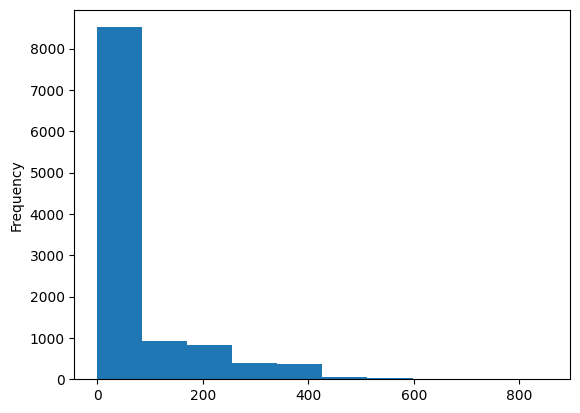

In [36]:
df['pdays'].plot.hist()
print(df.groupby(['pdays','deposit']).size())
df.drop('pdays',axis=1,inplace=True)

Поскольку после значения 18 в признаке campaign класс 1 deposit встречается редко по сравнению с классом 0, 
будем считать значения больше 18 в признаке campaign выбросами

In [38]:
print(df.groupby(['campaign','deposit']).size())

df = df[df['campaign']<18]

campaign  deposit
1         0          2233
          1          2557
2         0          1627
          1          1401
3         0           702
          1           616
4         0           454
          1           317
5         0           239
          1           139
6         0           172
          1            92
7         0            92
          1            47
8         0            96
          1            32
9         0            51
          1            21
10        0            38
          1            14
11        0            24
          1            16
12        0            25
          1             4
13        0            24
          1             6
14        0            11
          1             4
15        0             9
          1             4
16        0             7
          1             2
17        0             8
          1             6
18        0             8
19        0             5
20        0             4
          1         

In [39]:
print(df.groupby(['previous','deposit']).size())
df = df[df['previous']<16]

previous  deposit
0         0          4879
          1          3376
1         0           304
          1           582
2         0           237
          1           455
3         0           141
          1           293
4         0            73
          1           171
5         0            44
          1           121
6         0            34
          1            83
7         0            23
          1            54
8         0            21
          1            39
9         0            10
          1            24
10        0             4
          1            26
11        0             8
          1            15
12        0             6
          1            10
13        0             2
          1             9
14        0             1
          1             5
15        0             4
          1             1
16        0             2
17        0             8
          1             3
18        0             1
19        0             2
          1         

Проверим корреляцию между числовыми признаками

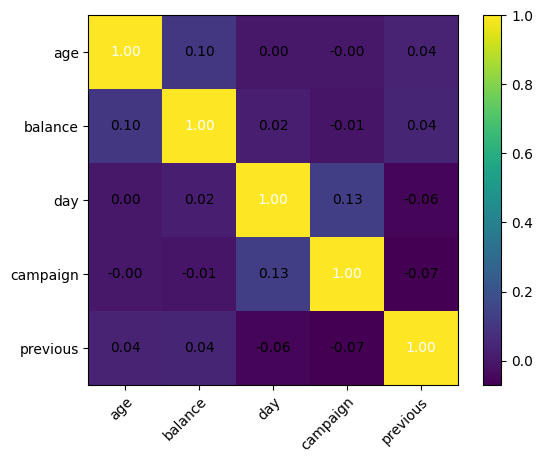

In [41]:
from mlxtend.plotting import heatmap
cols = ['age','balance','day','campaign','previous']

cm = np.corrcoef(df[cols].values.T)
gm = heatmap(cm, row_names=cols, column_names=cols)
plt.show()

Применим OneHotEncoding для кодирования категориальных переменных

In [43]:
cat_columns = ['job','marital','education','month','poutcome','contact']
for col in cat_columns:
    df = pd.concat([df.drop(col, axis=1),pd.get_dummies(df[col],prefix=col, prefix_sep='_', drop_first=True, dummy_na=False,dtype='int')],axis=1)
feature_cols = df.columns.tolist()
feature_cols.remove('deposit')
df = df[feature_cols + ['deposit']]    

In [44]:
df.head()

,age,default,balance,housing,loan,day,campaign,previous,job_blue-collar,job_entrepreneur,...,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,contact_telephone,contact_unknown,deposit
0,59,0,2343,1,0,5,1,0,0,0,...,1,0,0,0,0,0,1,0,1,1
1,56,0,45,0,0,5,1,0,0,0,...,1,0,0,0,0,0,1,0,1,1
2,41,0,1270,1,0,5,1,0,0,0,...,1,0,0,0,0,0,1,0,1,1
3,55,0,2476,1,0,5,1,0,0,0,...,1,0,0,0,0,0,1,0,1,1
4,54,0,184,0,0,5,2,0,0,0,...,1,0,0,0,0,0,1,0,1,1


Разобьем набор данных на тестовый и обучающий

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,feature_cols],df.loc[:,'deposit'],test_size=0.3,random_state=1, stratify=df.loc[:,'deposit'])

Для лучшей сходимости некоторых моделей МО используем стандартизацию

In [48]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
#X_test = X_test[cols_features+['education']]
column_names = X_train.columns.tolist()
X_train_std = X_train.copy()
X_test_std = X_test.copy()
column_to_std = ['age','balance','day','campaign','previous']
X_train_std[column_to_std]=stdsc.fit_transform(X_train[column_to_std])
X_test_std[column_to_std]=stdsc.transform(X_test[column_to_std])
X_train_std.head()

,age,default,balance,housing,loan,day,campaign,previous,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,contact_telephone,contact_unknown
9600,1.508410,0,-0.161912,1,1,-1.260032,-0.660335,-0.418126,0,0,...,0,0,0,0,0,0,0,1,0,0
222,-1.276000,1,-0.542769,1,0,-1.498696,-0.184308,-0.418126,1,0,...,0,0,0,0,0,0,0,1,0,1
4348,-1.529128,0,-0.128485,1,0,1.484600,-0.660335,-0.418126,0,0,...,0,1,0,0,0,0,0,1,0,1
5862,-0.432239,0,-0.443554,1,0,-1.021368,-0.184308,1.222574,0,0,...,0,1,0,0,0,0,0,0,0,0
1438,-1.529128,0,-0.418306,0,1,-0.902036,0.767746,-0.418126,0,0,...,0,0,0,0,0,0,0,1,0,0


Для начала попробуем модель логистической регрессии

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
#lr = LogisticRegression(C=0.04,penalty='l2',max_iter=200)
#param_grid = [{'penalty':['l2']}, {'C':[0.001, 0.01, 0.04,0.05,0.08,0.1,0.5,1, 10, 100, 1000]}]
#clf = GridSearchCV(estimator=lr, param_grid=param_grid,refit=True)
#clf.fit(X_train_std,y_train)
#print(clf.best_params_)
lr = LogisticRegression()
lr.fit(X_train_std,y_train)

y_pred_train = lr.predict(X_train_std)
y_pred_test = lr.predict(X_test_std)
scores = cross_val_score(estimator=lr, X=X_train_std,y=y_train, cv=10, scoring='accuracy')
print('accuracy_score при обучении:',accuracy_score(y_train, y_pred_train),'accuracy_score при тестировании:',accuracy_score(y_test,y_pred_test))
print('accuracy_score при перекрестной проверке:' ,scores.mean(),'+-',scores.std())

accuracy_score при обучении: 0.7054794520547946 accuracy_score при тестировании: 0.6967138981006934
accuracy_score при перекрестной проверке: 0.703537678296245 +- 0.018055767927280964


Поскольку набор данных сбалансирован, то можем использовать метрику accuracy. 
Видно, что логистическая регрессия недообучается, скорее всего линейные модели не способны охватить структуру данных.
Попробуем применить случайный лес.

In [52]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=300, random_state=1,max_depth=17, min_samples_leaf=1, max_leaf_nodes=800)
forest.fit(X_train,y_train)
y_pred_train = forest.predict(X_train)
y_pred_test = forest.predict(X_test)
scores = cross_val_score(estimator=forest, X=X_train,y=y_train, cv=5, scoring='accuracy')
print('accuracy_score при обучении:',accuracy_score(y_train, y_pred_train),'accuracy_score при тестировании:',accuracy_score(y_test,y_pred_test))
print('accuracy_score при перекрестной проверке:' ,scores.mean(),'+-',scores.std())


accuracy_score при обучении: 0.8904109589041096 accuracy_score при тестировании: 0.7289719626168224
accuracy_score при перекрестной проверке: 0.726673782214138 +- 0.008444938961202571


Случайный лес обучается лучше, но все равно обобщающая способность не поднимается выше даже при подборе гиперпараметров. Взгляем на различные типы ошибок, допускаемые моделью

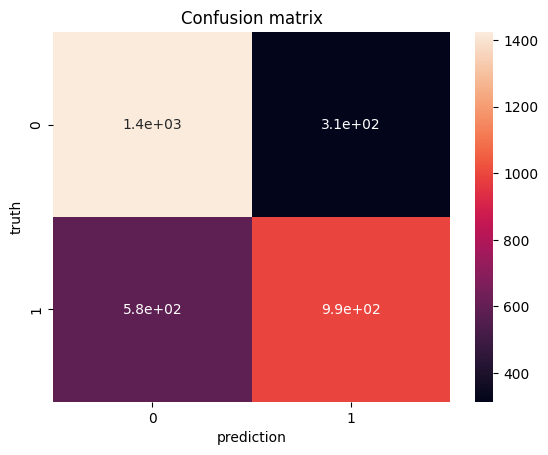

[[1424  314]
 [ 585  994]]


In [54]:
from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred_test)
sns.heatmap(confmat, annot=True)
plt.xlabel('prediction')
plt.ylabel('truth')
plt.title('Confusion matrix')
plt.show()
print(confmat)

Больше всего ошибок ложного пропуска (False positive) в размере 585, страдает полнота (recall) модели

In [56]:
from sklearn.metrics import recall_score
recall_score(y_test,y_pred_test)

0.629512349588347

Если учесть стратегию, то выгоднее сделать как можно больше депозитов, а следовательно нужно улучшить метрику полноты модели, то есть минимизировать ложный пропуск, метрика точности не так важна для этого случая (от того, что больше людей откажется от депозита, ничего страшного не произойдет).

In [58]:
class_weights =  {0: 1, 1: 5}
forest = RandomForestClassifier(n_estimators=300, random_state=1,max_depth=17, min_samples_leaf=1, max_leaf_nodes=800, class_weight = class_weights)
forest.fit(X_train,y_train)
y_pred_train = forest.predict(X_train)
y_pred_test = forest.predict(X_test)
scores = cross_val_score(estimator=forest, X=X_train,y=y_train, cv=5, scoring='recall')
print('recall_score при обучении:',recall_score(y_train, y_pred_train),'recall_score при тестировании:',recall_score(y_test,y_pred_test))
print('recall_score при перекрестной проверке:' ,scores.mean(),'+-',scores.std())

recall_score при обучении: 0.9986431478968792 recall_score при тестировании: 0.8752374920835972
recall_score при перекрестной проверке: 0.8295793758480325 +- 0.014853657729610859


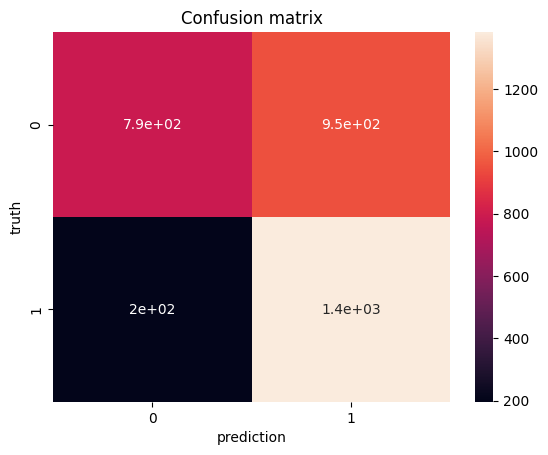

[[ 787  951]
 [ 197 1382]]


In [59]:
confmat = confusion_matrix(y_true=y_test,y_pred=y_pred_test)
sns.heatmap(confmat, annot=True)
plt.xlabel('prediction')
plt.ylabel('truth')
plt.title('Confusion matrix')
plt.show()
print(confmat)

Достигнуть более высоких показателей не удается с таким наобором данных. Конечно можно вернуть признак duration и тогда предсказания будут точнее, но ставилась задача построения модели, которая может делать прогноз еще до звонка человеку.